In [1]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import glob
import numpy as np
import xarray as xr

import pandas as pd
import geopandas as gpd
import scipy.stats as stats

import downscale as down

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

from scipy.stats import weibull_min

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

%run ../function/functions.ipynb

import warnings
warnings.filterwarnings('ignore')

## Test beta for IMERG data in Veneto

In [10]:
name, yy_s, yy_e = 'Coast Level', 2001, 2017
# name, yy_s, yy_e = 'Low Level', 2001, 2014
# name, yy_s, yy_e = 'Medium Level', 2001, 2017
# name, yy_s, yy_e = 'High Level', 2001, 2022

In [11]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson')
Veneto = gpd.read_file(veneto_dir)

In [12]:
data_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite','IMERG','3_hour',f'IMERG_Veneto_3h_2001_01_01_2023_12_31.nc')
DATA = xr.open_dataset(data_dir)
DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

lats = DATA['lat'].data
lons = DATA['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon_ref = np.size(lons)
nlat_ref = np.size(lats)

dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])

DATES = DATA['time'][:]

dset = np.array(DATA['PRE'])
dset[dset==np.nanmin(dset)]=0

DATA

<xarray.Dataset> Size: 477MB
Dimensions:  (time: 49672, lat: 30, lon: 40)
Coordinates:
  * time     (time) datetime64[ns] 397kB 2001-01-01 ... 2017-12-31T21:00:00
  * lat      (lat) float32 120B 44.05 44.15 44.25 44.35 ... 46.75 46.85 46.95
  * lon      (lon) float32 160B 10.05 10.15 10.25 10.35 ... 13.75 13.85 13.95
Data variables:
    PRE      (time, lat, lon) float64 477MB 0.0 0.0 0.0 0.0 ... 3.49 6.59 4.64
Attributes:
    description:  IMERG 3 hour data for Veneto region

In [13]:
PRE_daily = DATA.resample(time ='D').sum(dim='time', skipna=False)
DATES_daily = PRE_daily['time']

## Raingauge

In [14]:
rain_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','stations','data','Veneto')
RAIN = pd.read_csv(os.path.join(rain_dir, 'QC_stations_coords_utm32.csv'), sep=';')

if name == 'Coast Level':
    Id_station = '338_RO_Co.csv'
elif name == 'Low Level':
    Id_station = '274_VR_Mo.csv'
elif name == 'Medium Level':
    Id_station = '343_BL_Fo.csv'
elif name == 'High Level':
    Id_station = '348_NP_Ro.csv'
else:
    print('ERROR: Id dont found')

print(f'{name} station')
CL_INFO = RAIN[RAIN['File_Name']==Id_station]

CL_RAIN = pd.read_csv(os.path.join(rain_dir, 'Dati_QC_30min', CL_INFO['File_Name'].values[0]), sep=';')
CL_RAIN['dataora'] = pd.to_datetime(CL_RAIN['dataora'])
CL_RAIN['yy'] = pd.to_datetime(CL_RAIN['dataora']).dt.year
CL_RAIN['mm'] = pd.to_datetime(CL_RAIN['dataora']).dt.month
CL_RAIN['dd'] = pd.to_datetime(CL_RAIN['dataora']).dt.day
CL_RAIN['hh'] = pd.to_datetime(CL_RAIN['dataora']).dt.hour
CL_RAIN['mm'] = pd.to_datetime(CL_RAIN['dataora']).dt.minute

CL_RAIN[CL_RAIN['valore']>200] = 0

CL_RAIN.tail(3)

Coast Level station


,dataora,valore,qualita,yy,mm,dd,hh
528403,2017-11-30 10:00:00,0.0,1.0,2017,0,30,10
528404,2017-11-30 10:30:00,0.0,1.0,2017,30,30,10
528405,2017-11-30 11:00:00,0.0,1.0,2017,0,30,11


In [15]:
CL_RAIN['dataora'] = pd.to_datetime(CL_RAIN['dataora'])
CL_RAIN.set_index('dataora', inplace=True)

In [16]:
CL_RAIN = CL_RAIN[(CL_RAIN['yy']>=yy_s)&(CL_RAIN['yy']<=yy_e)]
OBS_ACUM = CL_RAIN['valore'].resample('D').sum()
OBS_1DY = pd.DataFrame({'PRE':OBS_ACUM.values, 'TIME':pd.to_datetime(OBS_ACUM.index)})

In [17]:
print(f'Station start time: {CL_RAIN.index[0]}')
print(f'Station end time  : {CL_RAIN.index[-1]}')

Station start time: 2001-01-01 00:00:00
Station end time  : 2017-11-30 11:00:00


In [18]:
print(f'Number of OBS time  : {len(OBS_1DY)}')
print(f'Number of IMERG time: {len(DATES_daily)}')

Number of OBS time  : 6178
Number of IMERG time: 6209


In [19]:
# Fit weibull for daily OBS time
OBS_1dy_df = xr.DataArray(OBS_1DY['PRE'].values,  coords={'time':OBS_1DY['TIME'].values}, dims=('time'))
OBS_NCW_1dy, OBS_YEARS = down.fit_yearly_weibull(OBS_1dy_df, thresh=1, maxmiss=36)

In [20]:
distances = haversine(lat2d, lon2d, 
                    CL_INFO['Lat'].values[0],CL_INFO['Lon'].values[0])

min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

clat = lats[min_index[0]]
clon = lons[min_index[1]]

TRMM_ML = dset[:,min_index[0],min_index[1]]

print(f"Nearest IMERG lat: {clat}")
print(f'Station lat       : {CL_INFO['Lat'].values[0]}')
print()
print(f"Nearest IMERG lon: {clon}")
print(f'Station lon       : {CL_INFO['Lon'].values[0]}')

Nearest IMERG lat: 45.04999923706055
Station lat       : 45.00466666

Nearest IMERG lon: 12.25
Station lon       : 12.24819444


In [21]:
IMERG_pixel_3h = dset[:,min_index[0],min_index[1]] # time, lat, lon
IMERG_pixel_1dy = PRE_daily['PRE'][:,min_index[0],min_index[1]].data

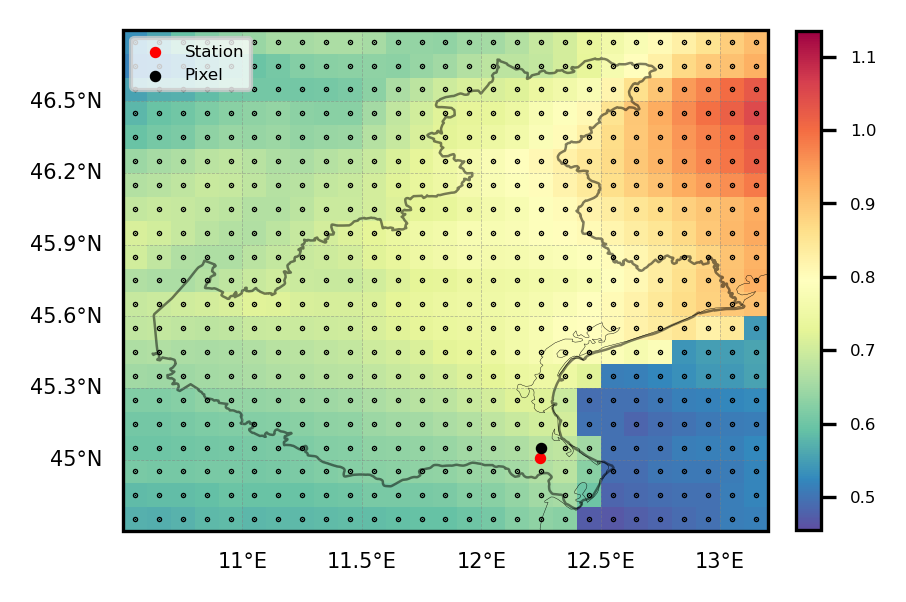

In [22]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(3,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.8], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)

a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(dset,axis=0),cmap=cmap)

ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o')

ax1.scatter(CL_INFO['Lon'], CL_INFO['Lat'], s=3, c='r', zorder=10, label='Station')
ax1.scatter(clon, clat, s=6, c='k', edgecolors='k', linewidth=0.3, zorder=10, label='Pixel')

plt.legend(fontsize=4, loc=2)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, pad=0.04, fraction=0.0358)
cbar.ax.tick_params(labelsize=4)

In [23]:
npix = 5 # default 3
buffer = 0.5*npix*0.1 # To define the limitis of box_3h

thresh = 1

L1 = 10
L0 = 0.0001

dt = 1 # time scale of the precipitation product [HOURS] (default 3 hours)

target_x = 0.0001 # subgrid spatial scale we want pwet at [km](default 0.0001 km)
target_t = 24 # target time scale, in [HOURS] (default 24 hours)

origin_x = 10 # linear spatial scale of origin gridded prcp [km] (default 25)
origin_t = 24 # time scale of origin gridded pecip [HOURS] (default 24 hours)

ninterp = 2000 # number of interpolation in time dimension

cube1size = 5 # lateral size of cube used to decide among how many single pixel average at smallest scale
tmax = 48 # maximum time scale of integration [HOURS]

acf='mar'

In [24]:
# Original data 3h time resolution
test = np.swapaxes(dset, 0, 2)
xrs0 = xr.DataArray(test,  coords={'lon':lons, 'lat':lats, 'time':DATES.data}, dims=('lon', 'lat', 'time'))
xrs = xrs0.where(xrs0 >= -0.001)

In [25]:
eps = 1e-4 # to make sure to include boundaires -> add an eps buffer
solat = clat - buffer + eps
nolat = clat + buffer + eps
ealon = clon + buffer + eps
welon = clon - buffer + eps
bcond = np.logical_and(
            np.logical_and( xrs.lat > solat, xrs.lat < nolat),
            np.logical_and( xrs.lon > welon, xrs.lon < ealon))

In [26]:
# Box 3h time resolution
box_3h = xrs.where(bcond, drop = True).load()
box_3h.shape

(5, 5, 49672)

In [27]:
# daily time resolution
xdaily0 = box_3h.resample(time ='{}h'.format(24)).sum(dim='time', skipna=False)
xdaily = xdaily0.dropna(dim='time', how='any')

In [28]:
# tsc = box_3h.loc[dict(lat = clat, lon = clon)]
tsc = xdaily.loc[dict(lat = clat, lon = clon)]
c_excesses = tsc.values[tsc.values > thresh] - thresh

In [29]:
# daily time resolution weibull fit
NCW = wei_fit(c_excesses)
pws = NCW[0]/box_3h.shape[2]
Ns = int(np.floor(pws*365.25))
Cs = NCW[1]
Ws = NCW[2]

In [95]:
smax = box_3h.shape[0] # max spatial scale
tscales = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 36, 48, 96])*dt
tscales = tscales[tscales < tmax + 0.001]
xscales = np.arange(1, smax+1)
xscales_km = xscales*L1
ntscales = np.size(tscales)
nsscales = np.size(xscales)
pwets = np.zeros((ntscales, nsscales))

In [31]:
for it, st in enumerate(tscales):
    datamat = box_3h.resample(time='{}h'.format(st)).sum(dim='time', skipna = False)

    for ix, sx in enumerate(xscales):

        # pixel scale
        if sx == 1:

            toskip = smax - cube1size
            if toskip % 2 == 0:
                buffer1 = toskip // 2
                buffer2 = toskip // 2
            else:
                buffer1 = toskip // 2
                buffer2 = buffer1 + 1

            if buffer2 > 0:
                aggt1 = datamat[buffer1:-buffer2, buffer1:-buffer2, :]
            else:
                aggt1 = datamat[buffer1:, buffer1:, :]

            # print('shape of p1 array = ', aggt1.shape)

            p1 = np.zeros((aggt1.shape[0], aggt1.shape[1]))

            for x in range(aggt1.shape[0]):
                for y in range(aggt1.shape[1]):
                    # print('Hello1')
                    p1[x, y] = wetfrac(aggt1[x, y, :].dropna(
                                        dim='time', how='any'), thresh)
            pwets[it, ix] = np.mean(p1)

        # largest scale: simple average
        elif sx == smax: 
            pwets[it, ix] = wetfrac( datamat.mean(dim=('lat', 'lon'),
                            skipna = False).dropna(dim='time', how='any'),
                            thresh)

        else: # intermediate scales
            c1 = np.zeros(4)
            c1[0] = wetfrac(datamat[:sx, :sx, :].mean(dim=('lat', 'lon'),
                            skipna=False).dropna(dim='time', how='any'),
                            thresh)
            c1[1] = wetfrac(datamat[-sx:, :sx, :].mean(dim=('lat', 'lon'),
                            skipna=False).dropna(dim='time', how='any'),
                            thresh)
            c1[2] = wetfrac(datamat[:sx, :sx, :].mean(dim=('lat', 'lon'),
                            skipna=False).dropna(dim='time', how='any'),
                            thresh)
            c1[3] = wetfrac(datamat[-sx:, :sx, :].mean(dim=('lat', 'lon'),
                            skipna=False).dropna(dim='time', how='any'),
                            thresh)
            pwets[it, ix] = np.mean(c1)

In [32]:
xscales_km = xscales*L1
xscales_2d, tscales_2d = np.meshgrid(xscales_km, tscales)

In [58]:
xscales_km

array([10, 20, 30, 40, 50])

In [85]:
tscales

[1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 36, 48]

In [33]:
ntscales = np.size(tscales)
nxscales = np.size(xscales)

tscales_int = np.linspace(np.min(tscales), np.max(tscales), ninterp) # 2000 valores entre min y max de time scale
pwmat_int = np.zeros((ninterp, nxscales)) # 2000,3

for col in range(nxscales):
    pwmat_int[:, col] = np.interp(tscales_int, tscales, pwets[:, col])

In [34]:
# found the wet fraction for the pixel
print(f'Spatial scale origin: {origin_x} km')
print(f'Time scale origin   : {origin_t} h')

pos_xmin = np.argmin(np.abs(origin_x - xscales_km))
pos_tmin = np.argmin(np.abs(origin_t - tscales_int))
pwet_origin = pwmat_int[pos_tmin, pos_xmin]

print(f'Wet fraction origin : {pwet_origin}')

Spatial scale origin: 10 km
Time scale origin   : 24 h
Wet fraction origin : 0.38634656564132275


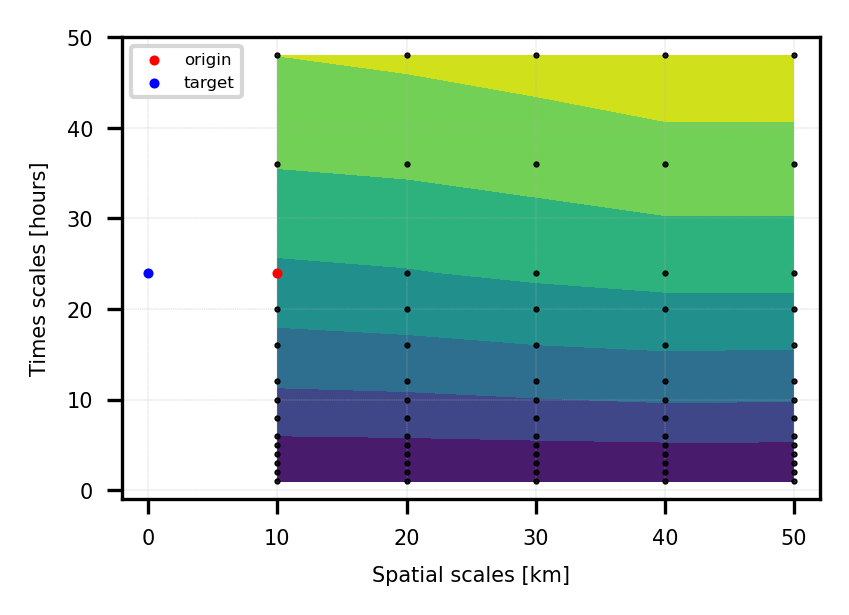

In [35]:
fig = plt.figure(figsize=(3,2),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================
ax1 = plt.subplot(gs[0, 0])

for ii in range(len(xscales_km)):
    for jj in range(len(xscales_2d)):
        ax1.plot(xscales_km[ii], tscales[jj], '.k', markersize=1)

ax1.contourf(xscales_2d, tscales_2d, pwets)

ax1.scatter(xscales_km[pos_xmin], 
            tscales_int[pos_tmin], 
            s=2, c='r', zorder=5,
            label='origin')

ax1.scatter(0.001, 24, s=2, c='b', zorder=5, label ='target')

ax1.set_ylabel('Times scales [hours]', fontsize=5)
ax1.set_xlabel('Spatial scales [km]', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)

ax1.set_xlim(-2, np.max(xscales_km)+2)
ax1.set_ylim(np.min(tscales)-2, np.max(tscales)+2)

ax1.grid(linewidth=0.1, linestyle='--')
ax1.legend(fontsize=4)

In [36]:
pw_min = np.min(pwets)
pw_max = np.max(pwets)
mypw = np.linspace(pw_min, pw_max, ninterp)

In [37]:
myU = np.zeros(ninterp)   # initialize linear slope
myX0 = np.zeros(ninterp)  # initialize linear intercept
myindices = np.zeros((ninterp, nxscales), dtype = int)

In [38]:
for ii in range(ninterp):
    Tvec = np.zeros(nxscales)
    for jj in range(nxscales):
        myindices[ii,jj] = np.argmin(np.abs(pwmat_int[:, jj] - mypw[ii]))
        Tvec[jj] = tscales_int[myindices[ii,jj]]
    warnings.simplefilter('ignore', np.RankWarning)
    # res = np.polyfit(Tvec[:2], xscales_km[:2], 1) # original
    res = np.polyfit(Tvec, xscales_km, 1) # modificacion arturo
    myU[ii] = res[0]
    myX0[ii] = res[1]

In [39]:
min_index = myindices.min(axis=1)
max_index = myindices.max(axis=1)
col_to_keep = np.logical_and(min_index > 0, max_index < ninterp-1)
mypw2 = mypw[col_to_keep]
U = myU[col_to_keep]
X0 = myX0[col_to_keep]

In [40]:
dthat = (target_x - X0) / U # compute time scale that would give me pwet
deltat = np.abs(dthat - target_t)
opt_deltat = np.min(deltat)
max_dt = 0.5 # half hour accuracy should suffice?
# set a TOLL value to check we are not too far away from the real deltat
if opt_deltat > max_dt:
    print('Taylor_Beta WARNING: not enough accuracy!')
    print('the time resolution of the coarse data might not be enough!')
    print('or try to increase the value of interp')
best_index = np.argmin(deltat)  # best prediction of 24 hour interval
pwet_target = mypw2[best_index]

## Scipy Interpolation

In [41]:
# Define your current spatial (km) and temporal (hours) scales
spatial_scale = np.array([10, 20, 30, 40, 50])  # Spatial in km
temporal_scale = np.copy(tscales)  # Temporal in hours

# Example matrix representing wet fraction at each spatial-temporal point
wet_fraction_matrix =  np.copy(pwets)

In [42]:
# Create an interpolator function, allowing extrapolation (bounds_error=False)
interpolator = RegularGridInterpolator(
    (temporal_scale, spatial_scale), wet_fraction_matrix, bounds_error=False, fill_value=None
)

# New spatial scale (down to 1 km resolution)
new_spatial_scale = np.linspace(0, 50, 100)  # 1 km resolution
# Keeping the temporal scale the same
new_temporal_scale = temporal_scale

# Create new grid for extrapolated data
new_spatial, new_temporal = np.meshgrid(new_spatial_scale, new_temporal_scale)

# Combine the spatial and temporal scales for interpolation
points_to_interpolate = np.array([new_temporal.ravel(), new_spatial.ravel()]).T

# Get the interpolated values (including extrapolated values)
new_wet_fraction = interpolator(points_to_interpolate).reshape(new_temporal.shape)

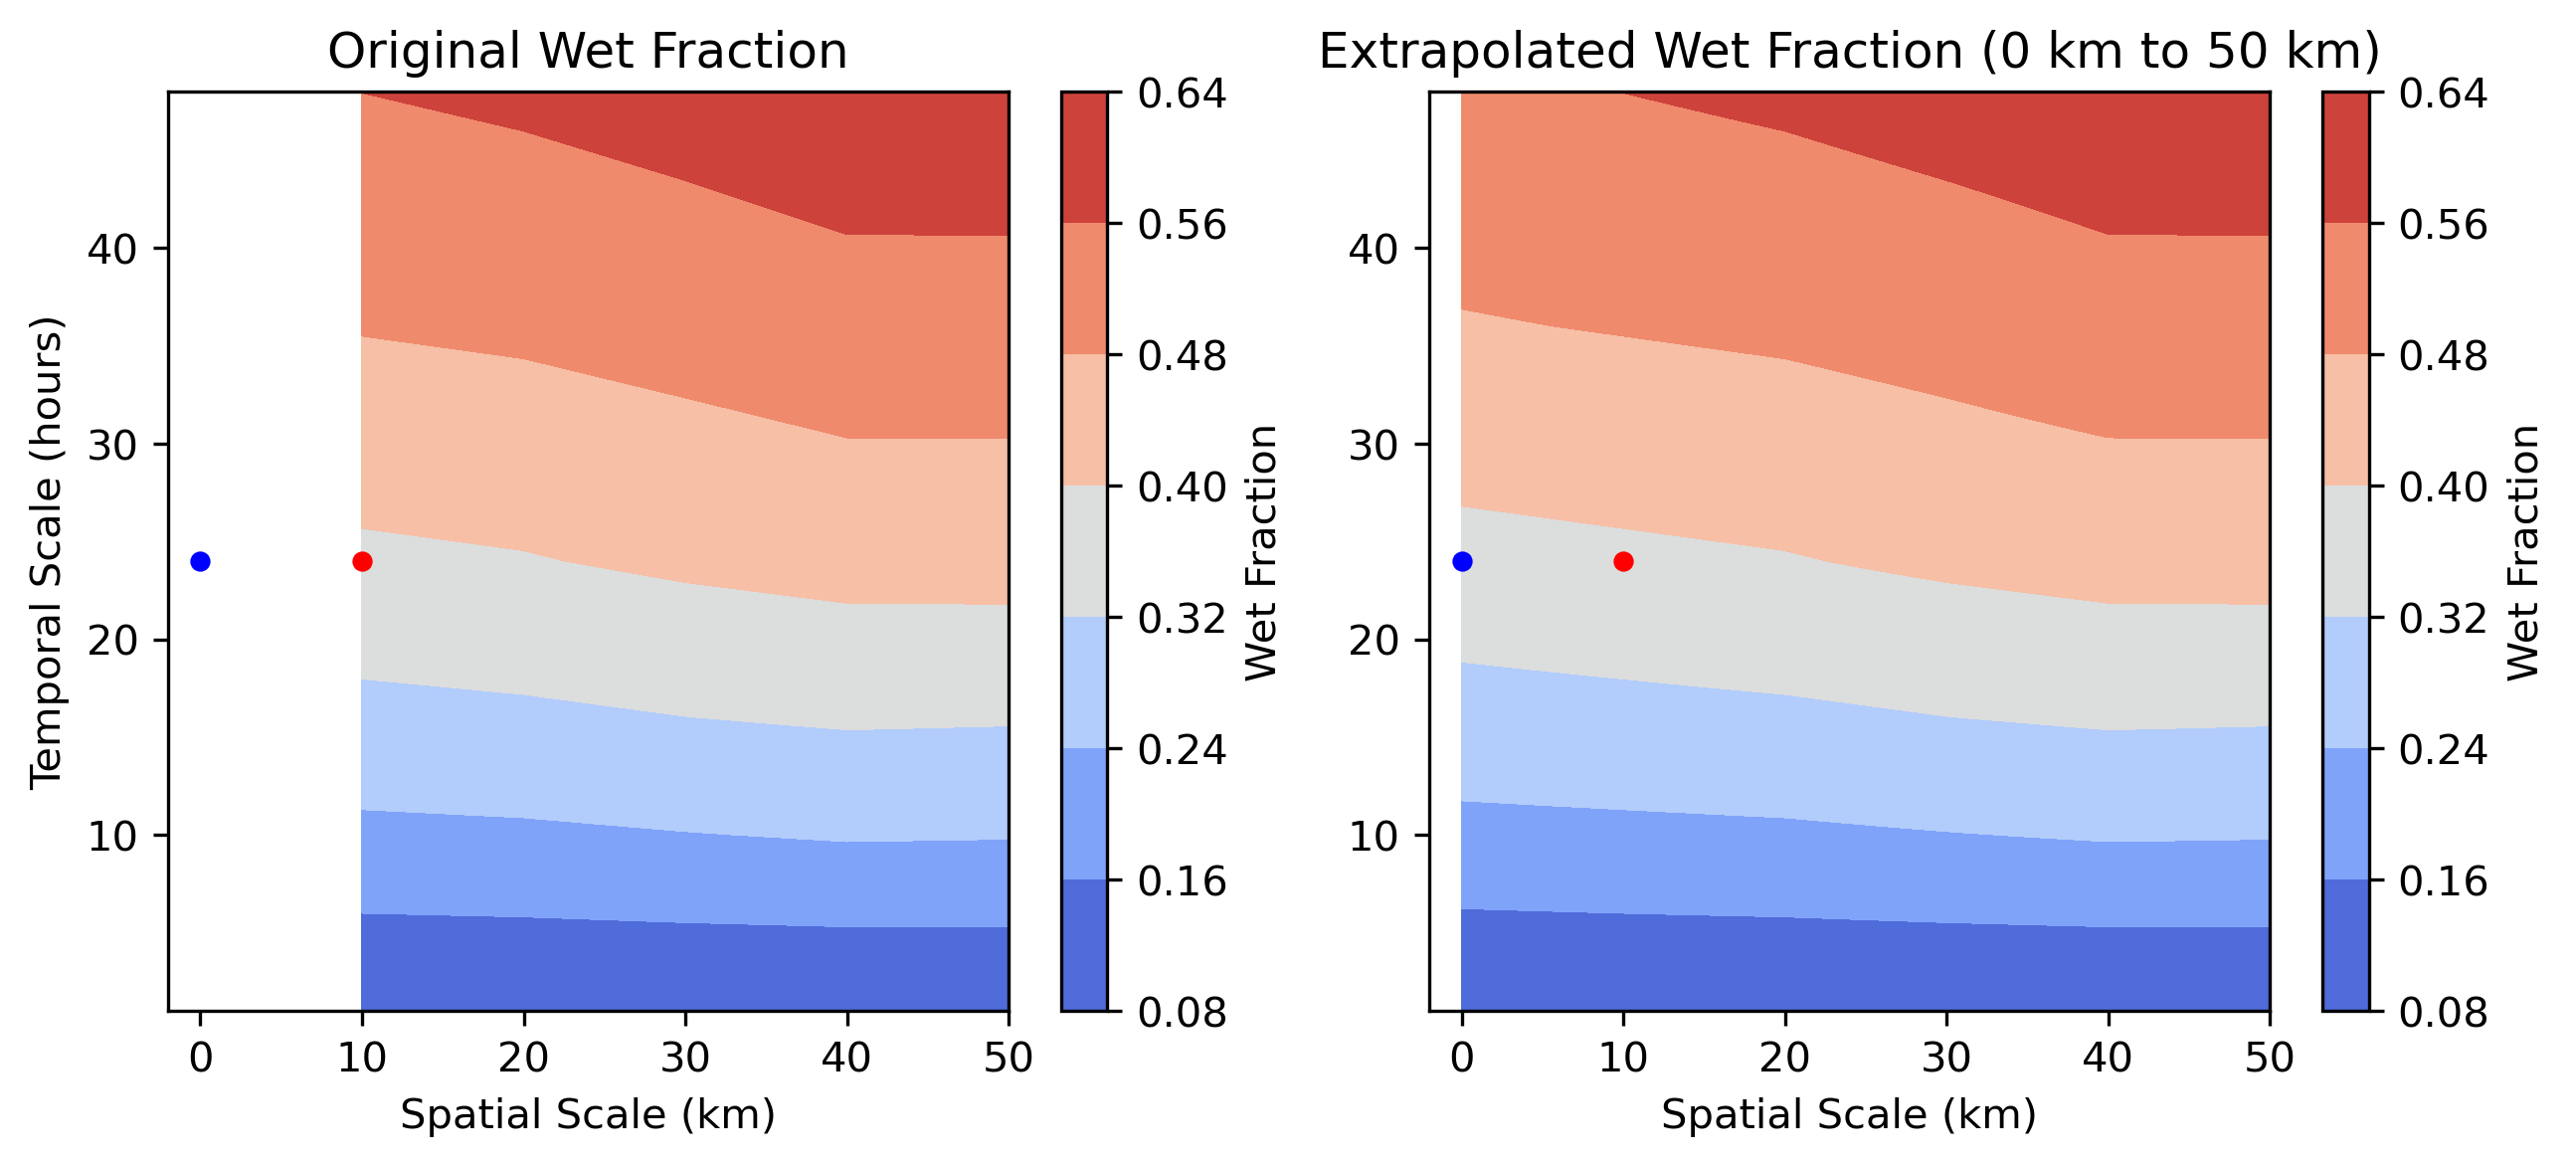

In [43]:
fig = plt.figure(figsize=(10,4),dpi=300)
gs = gridspec.GridSpec(1,2)

# ============================================================
ax1 = plt.subplot(gs[0, 0])
a1 = ax1.contourf(spatial_scale, temporal_scale, wet_fraction_matrix, cmap='coolwarm')
ax1.set_title('Original Wet Fraction')
ax1.set_xlabel('Spatial Scale (km)')
ax1.set_ylabel('Temporal Scale (hours)')
plt.colorbar(a1, label='Wet Fraction')
ax1.set_xlim(-2,50)

ax1.scatter(origin_x, 
            origin_t, 
            s=15, c='r', zorder=5,
            label='origin')

ax1.scatter(target_x, target_t, s=15, c='b', zorder=5, label ='target')

# ============================================================
ax1 = plt.subplot(gs[0, 1])
a1 = ax1.contourf(new_spatial, new_temporal, new_wet_fraction, cmap='coolwarm')
ax1.set_title('Extrapolated Wet Fraction (0 km to 50 km)')
ax1.set_xlabel('Spatial Scale (km)')
plt.colorbar(a1, label='Wet Fraction')
ax1.set_xlim(-2,50)

ax1.scatter(origin_x, 
            origin_t, 
            s=15, c='r', zorder=5,
            label='origin')

ax1.scatter(target_x, target_t, s=15, c='b', zorder=5, label ='target')

In [44]:
pos_xmin = np.argmin(np.abs(origin_x - new_spatial_scale))
pos_tmin = np.argmin(np.abs(origin_t - new_temporal_scale))
pwet_origin_new = new_wet_fraction[pos_tmin, pos_xmin]

print(f'Pixel wet fraction origin in New matrix: {pwet_origin_new}')
print(f'Pixel wet fraction origin in old matrix: {pwet_origin}')

Pixel wet fraction origin in New matrix: 0.38650004636475893
Pixel wet fraction origin in old matrix: 0.38634656564132275


In [45]:
pos_xmin = np.argmin(np.abs(target_x - new_spatial_scale))
pos_tmin = np.argmin(np.abs(target_t - new_temporal_scale))
pwet_target_new = new_wet_fraction[pos_tmin, pos_xmin]

print(f'Target wet fraction origin in New matrix: {pwet_target_new}')
print(f'Target wet fraction origin in old matrix: {pwet_target}')

Target wet fraction origin in New matrix: 0.3771782895796425
Target wet fraction origin in old matrix: 0.37617890889503414


In [46]:
beta_old = pwet_origin / pwet_target
beta_new = pwet_origin_new / pwet_target_new

print(f'Wet fraction old: {beta_old}')
print(f'Wet fraction new: {beta_new}')

Wet fraction old: 1.0270287794075283
Wet fraction new: 1.0247144574400222


In [47]:
res = {} 
# res['beta'] = beta_old
res['beta'] = beta_new
print(res['beta'])

1.0247144574400222


## Continuacion del processo de Downscaling

In [48]:
parnames = ['eps', 'alp'] if acf == 'mar' else ['d0', 'mu0']

In [49]:
rcorr = down.grid_corr(xdaily, plot=True, thresh=thresh)
gam_s = down.vrf(L1, L0, (rcorr['{}_s'.format(parnames[0])],
                        rcorr['{}_s'.format(parnames[1])]), acf=acf)

dcorr =  down.down_corr(rcorr['vdist'], rcorr['vcorr'], L1, acf=acf,
                    use_ave=True, opt_method='genetic', toll=0.005,
                    plot=True)

differential_evolution step 1: f(x)= 0.0010692955204717912
differential_evolution step 2: f(x)= 0.0010692955204717912
differential_evolution step 3: f(x)= 0.0010692955204717912
differential_evolution step 4: f(x)= 0.001026777032912609
differential_evolution step 5: f(x)= 0.001026777032912609
differential_evolution step 6: f(x)= 0.001026777032912609
Polishing solution with 'L-BFGS-B'
integration domain is zero


In [51]:
print('Downscaling pdf - global Weibull parameters')
par_acf = (dcorr['{}_d'.format(parnames[0])], dcorr['{}_d'.format(parnames[1])])

Nd, Cd, Wd, gam_d, fval_w = down.down_wei(Ns, Cs, Ws, L1, L0, res['beta'], par_acf, acf=acf)

print('Downscaling pdf - yearly Weibull parameters')
NCWy, YEARSy = down.fit_yearly_weibull(tsc, thresh=thresh, maxmiss=100)
NYd, CYd, WYd, _, _ = down.down_wei(NCWy[:,0], NCWy[:,1], NCWy[:,2], L1, L0, res['beta'], par_acf, acf=acf)

Downscaling pdf - global Weibull parameters
Downscaling pdf - yearly Weibull parameters


In [52]:
res['NYs'] = NCWy[:,0] # yearly Weibull parameters
res['CYs'] = NCWy[:,1] # yearly Weibull parameters
res['WYs'] = NCWy[:,2] # yearly Weibull parameters
res['NYd'] = NYd # Nd, Cd, Wd (downscaled parameters)
res['CYd'] = CYd # Nd, Cd, Wd (downscaled parameters)
res['WYd'] = WYd # Nd, Cd, Wd (downscaled parameters)

In [55]:
Tr = np.array([10, 20, 50, 100]) # pass
Fi = 1-1/Tr
res['Tr'] = Tr
# x0 = 150.0
x0 = 9.0*np.mean(CYd)
res['mev_d'] = down.mev_quant(Fi, x0, NYd, CYd, WYd, thresh=thresh)[0] # Computes the MEV quantile for given non exceedance probability
res['mev_s'] = down.mev_quant(Fi, x0, NCWy[:,0], NCWy[:,1], NCWy[:,2],thresh=thresh)[0] # Computes the MEV quantile for given non exceedance probability

res['gam_d'] = gam_d # variance reduction function downscale
res['gam_s'] = gam_s # variance reduction factor
res['Nd'] = Nd # Nd, Cd, Wd (downscaled parameters)
res['Cd'] = Cd # Nd, Cd, Wd (downscaled parameters)
res['Wd'] = Wd # Nd, Cd, Wd (downscaled parameters)
res['Ns'] = Ns # global Weibull parameters
res['Cs'] = Cs # global Weibull parameters
res['Ws'] = Ws # global Weibull parameters
res['{}_s'.format(parnames[0])] = rcorr['{}_s'.format(parnames[0])]
res['{}_s'.format(parnames[1])] = rcorr['{}_s'.format(parnames[1])]
res['{}_d'.format(parnames[0])] = dcorr['{}_d'.format(parnames[0])]
res['{}_d'.format(parnames[1])] = dcorr['{}_d'.format(parnames[1])]
res['corr_down_success'] =        dcorr['success']
res['corr_down_funval'] =         dcorr['funval']
res['w_down_funval'] = fval_w[0] # function value at the end of numerical minimization
res['thresh'] = thresh # threshold used in the analysis
res['clat'] = clat
res['clon'] = clon

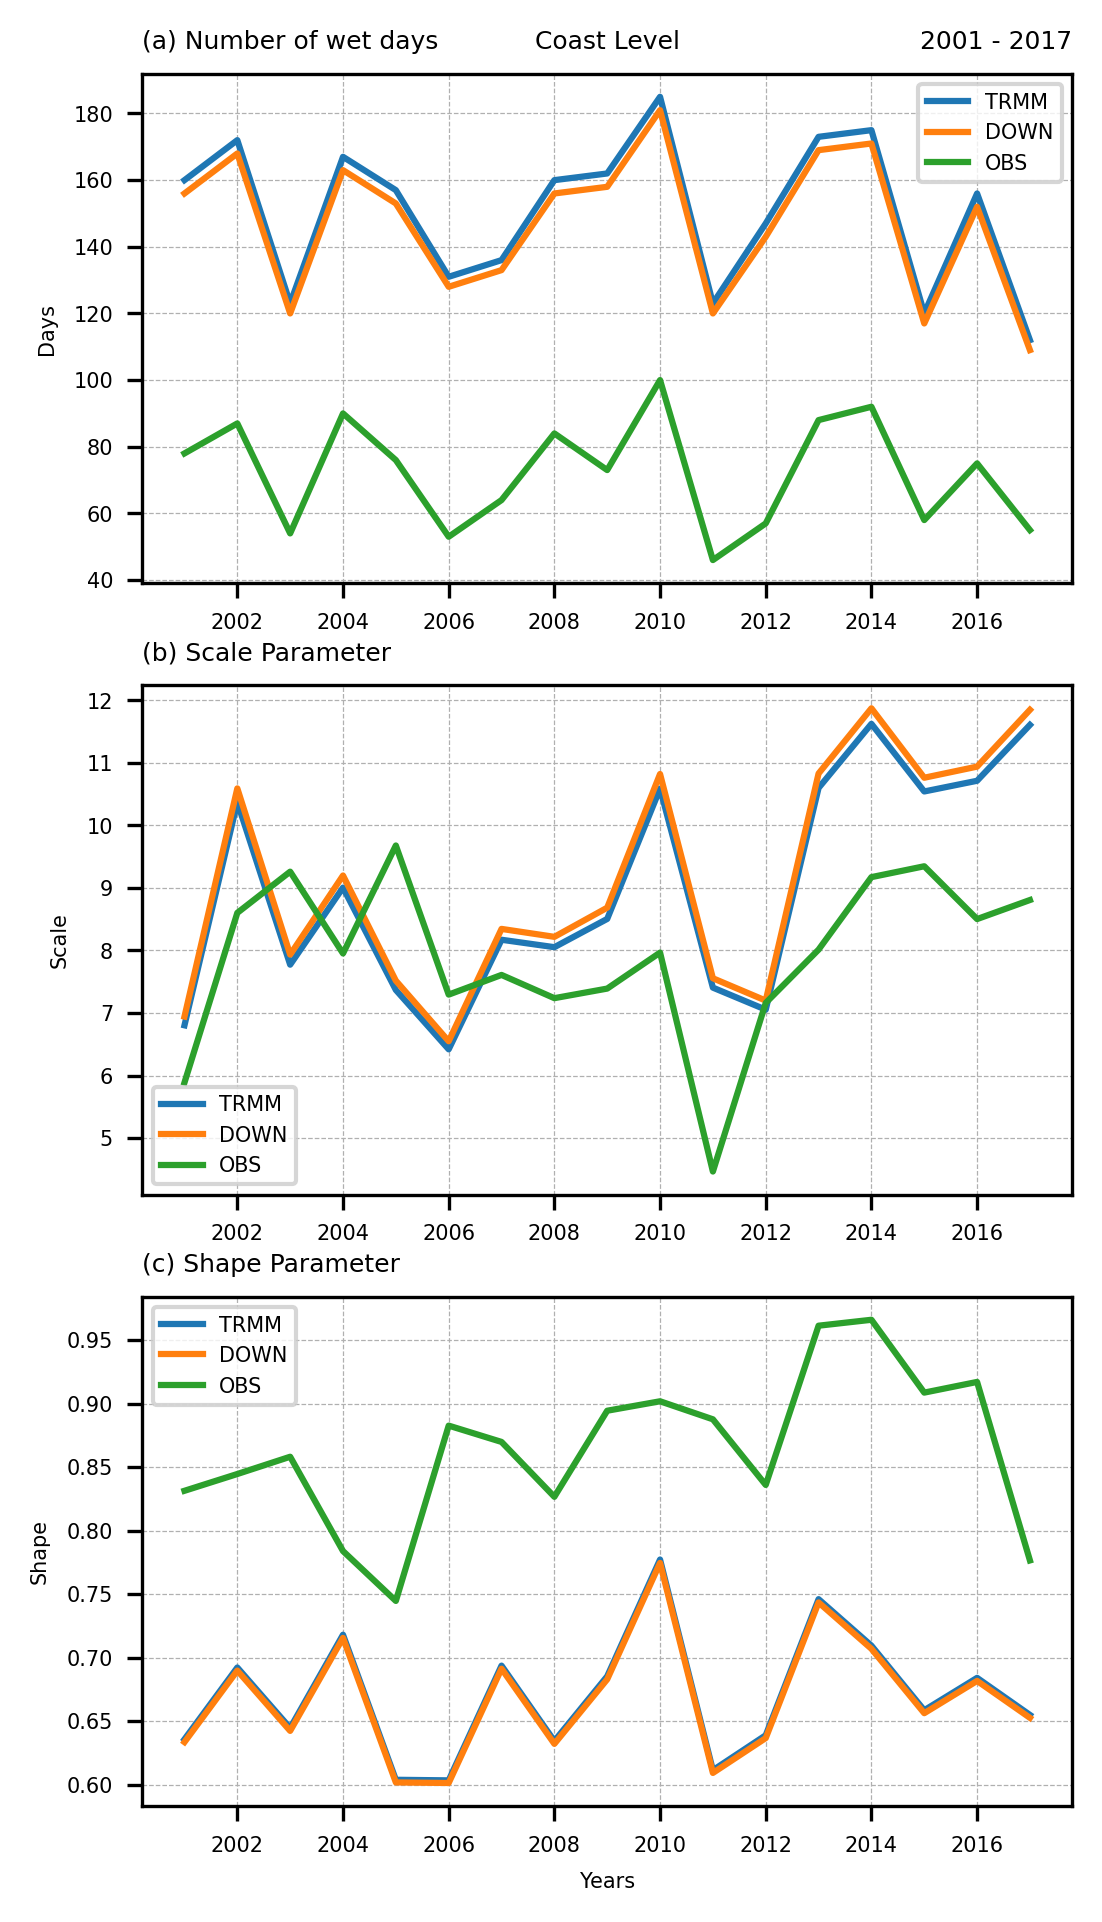

In [56]:
fig = plt.figure(figsize=(4,7.5),dpi=300)
gs = gridspec.GridSpec(3,1)

# =================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(YEARSy, res['NYs'], label=f'TRMM')
ax1.plot(YEARSy, res['NYd'], label=f'DOWN')
ax1.plot(OBS_YEARS, OBS_NCW_1dy[:,0], label='OBS')

ax1.legend(fontsize=5)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(a) Number of wet days',loc='left',fontsize=6)
ax1.set_title(f'{yy_s} - {yy_e}',loc='right',fontsize=6)
ax1.set_title(f'{name}',loc='center',fontsize=6)
ax1.set_ylabel('Days', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)

# =================================================================
ax1 = plt.subplot(gs[1, 0])
ax1.plot(YEARSy, res['CYs'], label=f'TRMM')
ax1.plot(YEARSy, res['CYd'], label=f'DOWN')
ax1.plot(OBS_YEARS, OBS_NCW_1dy[:,1], label='OBS')

ax1.legend(fontsize=5)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(b) Scale Parameter',loc='left',fontsize=6)
ax1.set_ylabel('Scale', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)

# =================================================================
ax1 = plt.subplot(gs[2, 0])
ax1.plot(YEARSy, res['WYs'], label=f'TRMM')
ax1.plot(YEARSy, res['WYd'], label=f'DOWN')
ax1.plot(OBS_YEARS, OBS_NCW_1dy[:,2], label='OBS')

ax1.legend(fontsize=5)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(c) Shape Parameter',loc='left',fontsize=6)
ax1.set_ylabel('Shape', fontsize=5)
ax1.set_xlabel('Years', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)

'24h'